<a href="https://colab.research.google.com/github/andreyxz2000/home/blob/main/LightGBM_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт датасета...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# путь к файлу
path = "/content/drive/MyDrive/Final_dfs/final_data_term88.csv"

# загрузка данных в датасет
data = pd.read_csv(path, skiprows=1, delimiter=",")
data = data.rename(columns={})
data.columns = ['Time', 'CPU', 'Memory', 'System Disk Usage']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Визуальный осмотр данных для датасета...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233570 entries, 0 to 233569
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Time               233570 non-null  object 
 1   CPU                233570 non-null  float64
 2   Memory             190301 non-null  float64
 3   System Disk Usage  43212 non-null   float64
dtypes: float64(3), object(1)
memory usage: 7.1+ MB


In [ ]:

print (f'CPU:    min={data.CPU.min()}, max={data.CPU.max()}')
print (f'Memory: min={data.Memory.min()}, max={data.Memory.max()}')
print (f"Disk:   min:{data['System Disk Usage'].min()}, max:{data['System Disk Usage'].max()}")


CPU:    min=3.28125, max=100.0
Memory: min=15.334812045904464, max=99.54558557089344
Disk:   min:74.79945408308541, max:80.39117499779081


In [ ]:
print (f'всего значений CPU {len(data.CPU)} уникальных {len(pd.unique(data.CPU))}')
print (f'всего значений Memory {len(data.Memory)} уникальных {len(pd.unique(data.Memory))}')
print (f'всего значений Disk {len(data["System Disk Usage"])} уникальных {len(pd.unique(data["System Disk Usage"]))}')

всего значений CPU 233570 уникальных 13153
всего значений Memory 233570 уникальных 175907
всего значений Disk 233570 уникальных 1800


In [ ]:
data.isnull().sum() # нулевых значений до нормализации НЕТ.

Time                      0
CPU                       0
Memory                43269
System Disk Usage    190358
dtype: int64

In [ ]:
data[::10_000]

,Time,CPU,Memory,System Disk Usage
0,2022-11-01 00:02:00,13.554688,33.544053,77.931603
10000,2022-11-07 22:43:00,6.367187,36.427495,77.899202
20000,2022-11-14 21:23:00,11.054688,67.563908,77.850108
30000,2022-11-21 20:03:00,43.593750,63.440942,78.134849
40000,2022-11-28 18:51:00,9.453125,46.220545,77.388632
50000,2022-12-05 17:31:00,8.906250,41.302597,NaN
60000,2022-12-12 16:11:00,83.789062,70.512416,NaN
70000,2022-12-19 16:11:00,21.171875,51.396325,NaN
80000,2022-12-26 14:51:00,15.976562,70.527198,NaN
90000,2023-01-02 13:31:00,7.773438,35.101303,NaN


Text(0.5, 1.0, 'Disk')

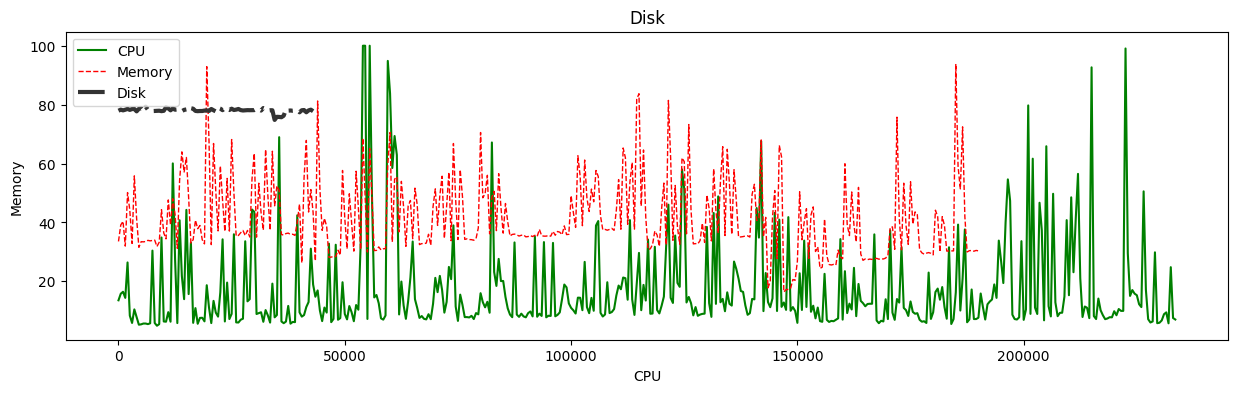

In [ ]:
import matplotlib.pyplot as plt

# построение графиков (из гравика растущий тренд)
fig, ax = plt.subplots(figsize = (15,4))
# plotting daily data
ax.plot(data.CPU[::500],ls='-', markersize=2, color='green', label='CPU')
# plotting 7-day rolling data
ax.plot(data.Memory[::500],ls='--', linewidth=1,color='red', label='Memory')
# plotting annual rolling data
ax.plot(data['System Disk Usage'][::500],ls='-.', color='0.2', linewidth=3, label='Disk')
# Beautification of plot

ax.legend()
ax.set_xlabel('CPU')
ax.set_ylabel('Memory')
ax.set_title('Disk')

In [ ]:
data['Time'] = pd.to_datetime(data['Time'])
data.dtypes

Time                 datetime64[ns]
CPU                         float64
Memory                      float64
System Disk Usage           float64
dtype: object

# Функция для классификации

In [ ]:
import pandas as pd



"""
Параметры:
df - датафрейм
column - столбец df, по которому вычисляем превышение
level - уровень параметра нагрузки, свыше которого требуется определять превышение и выдавать сигнал
time - горизонт предсказания (т.е. за сколько времени модель должна предсказывать событие)
"""

def LightGBM_class(df, column, level, time):

    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import confusion_matrix
    import pandas as pd

    df = df.loc[:, ['Time', column]]
    # Удаление всех NaN значений из DataFrame
    df = df.dropna()

    # преобразование столбца 'Time' в формат datetime
    df['Time'] = pd.to_datetime(df['Time'])

    # создание словарей для перевода в One Hot Encoding
    week_day_dict = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    month_dict = {
        'January': 1,
        'February': 2,
        'March': 3,
        'April': 4,
        'May': 5,
        'June': 6,
        'July': 7,
        'August': 8,
        'September': 9,
        'October': 10,
        'November': 11,
        'December': 12
    }



    # добавление столбцов с днем недели, месяцем и днем месяца
    df['Week_day'] = df['Time'].dt.day_name()
    df['Month'] = df['Time'].dt.month_name()
    df['Day'] = df['Time'].dt.day
    df['Hour'] = df['Time'].dt.hour
    df['Minute'] = df['Time'].dt.minute

    # Преобразование строковых значений в числа из словарей
    df['Week_day'] = df['Week_day'].replace(week_day_dict)
    df['Month'] = df['Month'].replace(month_dict)

    # перевод категориальных признаков в One Hot Encoding
    week_day_ohe = pd.get_dummies(df['Week_day'], prefix='Week_day_ohe')
    month_ohe = pd.get_dummies(df['Month'], prefix='Month_ohe')
    day_ohe = pd.get_dummies(df['Day'], prefix='Day_ohe')
    hour_ohe = pd.get_dummies(df['Hour'], prefix='Hour_ohe')
    minute_ohe = pd.get_dummies(df['Minute'], prefix='Minute_ohe')

    # объединение датафрейма с One Hot Encoding
    df = pd.concat([df, week_day_ohe, month_ohe, day_ohe, hour_ohe, minute_ohe], axis=1)

    # удаление столбцов с категориальными признаками
    df = df.drop(['Week_day', 	'Month' , 	'Day' , 	'Hour',  	'Minute'], axis=1)

    # устанавливаем столбец "Time" в качестве индекса
    df.set_index('Time', inplace=True)

    interval = time
    # в Х пишем верхнюю часть датафрейма без хвоста, равного  interval
    x = df.loc[df.index[:len(df)-interval], :]

    # В Y пишем столбец CPU без верхних  interval-строк
    y = df.loc[df.index[interval:], column]
    y = pd.DataFrame(y, columns=[column])

    print('x.shape=',x.shape)
    print('y.shape=',y.shape)

    # Проверяем условие и присваиваем значения 1 или 0
    y[column] = y[column].apply(lambda x: 1 if x > level else 0)

    # Преобразуем датасеты в массивы NumPy
    x = np.array(x)
    y = np.array(y)

    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=0)
    print('\n')
    print('x_train.shape=',x_train.shape)
    print('y_train.shape=',y_train.shape)
    print('Число классов "1" в y_train =',np.sum(y_train, axis=0))
    print('\n')
    print('x_valid.shape=',x_valid.shape)
    print('y_valid.shape=',y_valid.shape)
    print('Число классов "1" в y_valid =',np.sum(y_valid, axis=0))
    print('\n')
    print('x_test.shape=',x_test.shape)
    print('y_test.shape=',y_test.shape)
    print('Число классов "1" в y_test =',np.sum(y_test, axis=0))
    print('\n')

    # build the lightgbm model
    import lightgbm as lgb
    clf = lgb.LGBMClassifier()
    clf.fit(x_train, y_train)
    # predict the results
    y_pred=clf.predict(x_test)
    y_pred_train = clf.predict(x_train)
    # print the scores on training and test set
    print('\n')
    print('\n')
    print('Training set score: {:.4f}'.format(clf.score(x_train, y_train)))

    print('Test set score: {:.4f}'.format(clf.score(x_test, y_test)))
    import seaborn as sns
    # visualize confusion matrix with seaborn heatmap

    cm = confusion_matrix(y_test, y_pred)

    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                    index=['Predict Positive:1', 'Predict Negative:0'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

    return


## Классификация на Memory через функцию

x.shape= (170142, 128)
y.shape= (170142, 1)


x_train.shape= (102084, 128)
y_train.shape= (102084, 1)
Число классов "1" в y_train = [1090]


x_valid.shape= (34029, 128)
y_valid.shape= (34029, 1)
Число классов "1" в y_valid = [383]


x_test.shape= (34029, 128)
y_test.shape= (34029, 1)
Число классов "1" в y_test = [360]




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)






Training set score: 0.9996
Test set score: 0.9979


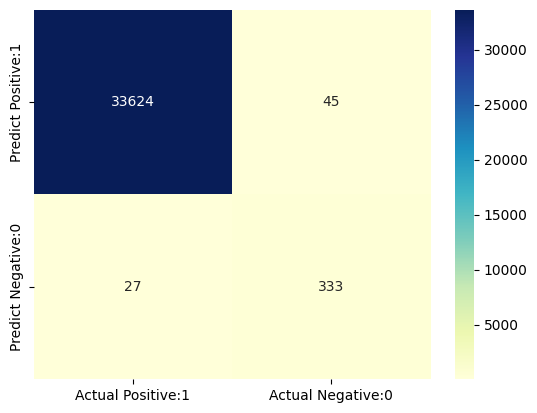

In [ ]:
"""
-  df - датафрейм (data)
-  column - столбец df, по которому вычисляем превышение ('Memory')
-  level - уровень параметра нагрузки, свыше которого требуется определять превышение и выдавать сигнал (80)
-  time - горизонт предсказания (т.е. за сколько времени модель должна предсказывать событие):
   определяем интервал в 2 недели (20160 минут = количеству строк датафрейма ) - за столько времени нам нужно предсказывать превышение Memory 80%
"""
LightGBM_class(data, 'Memory', 80, 20160)


# CPU

## Создаем датафрейм CPU и обогощаем его признаками

In [ ]:
df_cpu = data.loc[:, ['Time', 'CPU']]
df_cpu

,Time,CPU
0,2022-11-01 00:01:00,14.218750
1,2022-11-01 00:02:00,13.554688
2,2022-11-01 00:03:00,14.453125
3,2022-11-01 00:04:00,26.015625
4,2022-11-01 00:05:00,15.390625
...,...,...
233566,2023-04-12 07:24:00,50.117188
233567,2023-04-12 07:25:00,20.898438
233568,2023-04-12 07:26:00,11.328125
233569,2023-04-12 07:27:00,72.070312


In [ ]:
# преобразование столбца 'Time' в формат datetime
df_cpu['Time'] = pd.to_datetime(df_cpu['Time'])

# создание словарей для перевода в One Hot Encoding
week_day_dict = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

month_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}



# добавление столбцов с днем недели, месяцем и днем месяца
df_cpu['Week_day'] = df_cpu['Time'].dt.day_name()
df_cpu['Month'] = df_cpu['Time'].dt.month_name()
df_cpu['Day'] = df_cpu['Time'].dt.day
df_cpu['Hour'] = df_cpu['Time'].dt.hour
df_cpu['Minute'] = df_cpu['Time'].dt.minute

# Преобразование строковых значений в числа из словарей
df_cpu['Week_day'] = df_cpu['Week_day'].replace(week_day_dict)
df_cpu['Month'] = df_cpu['Month'].replace(month_dict)

# перевод категориальных признаков в One Hot Encoding
week_day_ohe = pd.get_dummies(df_cpu['Week_day'], prefix='Week_day_ohe')
month_ohe = pd.get_dummies(df_cpu['Month'], prefix='Month_ohe')
day_ohe = pd.get_dummies(df_cpu['Day'], prefix='Day_ohe')
hour_ohe = pd.get_dummies(df_cpu['Hour'], prefix='Hour_ohe')
minute_ohe = pd.get_dummies(df_cpu['Minute'], prefix='Minute_ohe')

# объединение датафрейма с One Hot Encoding
df_cpu = pd.concat([df_cpu, week_day_ohe, month_ohe, day_ohe, hour_ohe, minute_ohe], axis=1)

# удаление столбцов с категориальными признаками
df_cpu = df_cpu.drop(['Week_day', 	'Month' , 	'Day' , 	'Hour',  	'Minute'], axis=1)

# устанавливаем столбец "Time" в качестве индекса
df_cpu.set_index('Time', inplace=True)

df_cpu

,CPU,Week_day_ohe_1,Week_day_ohe_2,Week_day_ohe_3,Week_day_ohe_4,Week_day_ohe_5,Week_day_ohe_6,Week_day_ohe_7,Month_ohe_1,Month_ohe_2,...,Minute_ohe_50,Minute_ohe_51,Minute_ohe_52,Minute_ohe_53,Minute_ohe_54,Minute_ohe_55,Minute_ohe_56,Minute_ohe_57,Minute_ohe_58,Minute_ohe_59
Time,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:01:00,14.218750,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:02:00,13.554688,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:03:00,14.453125,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:04:00,26.015625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:05:00,15.390625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-12 07:24:00,50.117188,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-12 07:25:00,20.898438,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-04-12 07:26:00,11.328125,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Регрессия

## Создание входных и выходных X и Y

In [ ]:
# определяем интервал в 2 недели (20160 минут = количеству строк датафрейма ) - за столько времени нам нужно предсказывать превышение CPU 75%
interval = 20160
# в Х пишем верхнюю часть датафрейма без хвоста, равного  interval
x = df_cpu.loc[df_cpu.index[:len(df_cpu)-interval], :]

# В Y пишем столбец CPU без верхних  interval-строк
y = df_cpu.loc[df_cpu.index[interval:], 'CPU']
y = pd.DataFrame(y, columns=['CPU'])

"""
from sklearn.preprocessing import MinMaxScaler
# Создаем объект минимакс-масштабирования
scaler = MinMaxScaler()

# Масштабируем столбец "CPU"
x['CPU'] = scaler.fit_transform(x[['CPU']])
"""
print(x.shape)
print(y.shape)



(213411, 129)
(213411, 1)


In [ ]:
x

,CPU,Week_day_ohe_1,Week_day_ohe_2,Week_day_ohe_3,Week_day_ohe_4,Week_day_ohe_5,Week_day_ohe_6,Week_day_ohe_7,Month_ohe_1,Month_ohe_2,...,Minute_ohe_50,Minute_ohe_51,Minute_ohe_52,Minute_ohe_53,Minute_ohe_54,Minute_ohe_55,Minute_ohe_56,Minute_ohe_57,Minute_ohe_58,Minute_ohe_59
Time,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:01:00,14.218750,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:02:00,13.554688,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:03:00,14.453125,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:04:00,26.015625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:05:00,15.390625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 07:07:00,26.093750,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-29 07:08:00,8.632813,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-29 07:09:00,9.960938,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y

,CPU
Time,
2022-11-15 00:02:00,8.632813
2022-11-15 00:03:00,8.867188
2022-11-15 00:04:00,13.828125
2022-11-15 00:05:00,8.242188
2022-11-15 00:06:00,9.570312
...,...
2023-04-12 07:24:00,50.117188
2023-04-12 07:25:00,20.898438
2023-04-12 07:26:00,11.328125


## Обучение модели


Документация: https://lightgbm.readthedocs.io/en/v3.3.2/

Пример по бинарной классификации и регрессии: https://habr.com/ru/companies/skillfactory/articles/530594/

Еще по классификации: https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python

In [ ]:
# check lightgbm version
import lightgbm
print(lightgbm.__version__)

3.3.5


In [ ]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Преобразуем датасеты в массивы NumPy
x = np.array(x)
y = np.array(y)

"""
# Разбиваем данные на обучающую, валидационную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
"""

# Определение размеров выборок
train_size = int(len(x) * 0.6)  # 60% для обучения
valid_size = int(len(x) * 0.2)  # 20% для валидации
test_size = len(x) - train_size - valid_size  # остаток для тестирования

# Разделение на обучающую, валидационную и тестовую выборки
x_train = x[:train_size]
x_valid = x[train_size:train_size+valid_size]
x_test = x[train_size+valid_size:]

y_train = y[:train_size]
y_valid = y[train_size:train_size+valid_size]
y_test = y[train_size+valid_size:]

# Создаем объекты Dataset для обучающей, валидационной и тестовой выборок
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid)

# Определение параметров модели
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 200,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Обучение модели
num_iterations = 1000
model = lgb.train(params, train_data, num_iterations, valid_sets=[valid_data], verbose_eval=False)




/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [ ]:
# Получение прогнозов на тестовой выборке
y_pred = model.predict(x_test)


В задачах регрессии, когда требуется предсказать непрерывную переменную, распространенными метриками точности являются:

1. Средняя абсолютная ошибка (Mean Absolute Error, MAE): Это средняя абсолютная разница между предсказанными и фактическими значениями. Чем меньше MAE, тем лучше. Метрика MAE показывает среднюю отклонение предсказаний от фактических значений без учета направления ошибки.

2. Среднеквадратичная ошибка (Mean Squared Error, MSE): Это среднее значение квадрата разницы между предсказанными и фактическими значениями. Чем меньше MSE, тем лучше. Метрика MSE дает больший вес большим ошибкам.

3. Коэффициент детерминации (Coefficient of Determination, R-squared): Это мера объяснительной способности модели, отображающая, насколько хорошо модель соответствует данным. Значение R-squared находится в диапазоне от 0 до 1, где 1 означает идеальное соответствие модели данным, а 0 означает, что модель не объясняет вариацию в данных лучше, чем просто среднее значение. Чем ближе R-squared к 1, тем лучше.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE): {0:0.4f}'.format(mae))
print('Mean Squared Error (MSE): {0:0.4f}'.format(mse))
print('R-squared: {0:0.4f}'.format(r2))


Mean Absolute Error (MAE): 10.3164
Mean Squared Error (MSE): 230.7773
R-squared: 0.0381


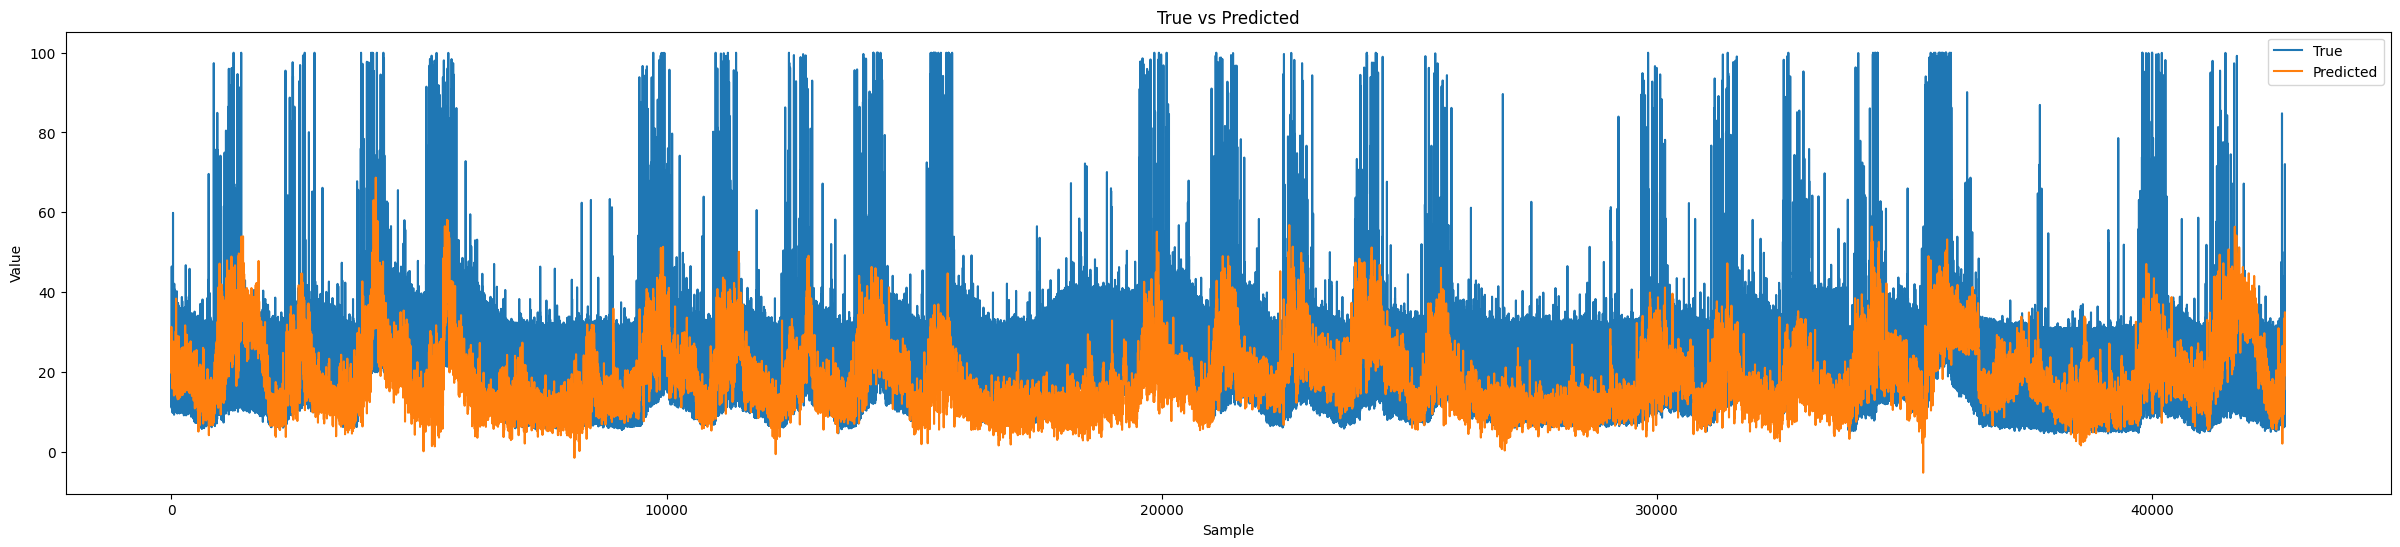

In [ ]:
import matplotlib.pyplot as plt

# График истинных значений и предсказаний
plt.figure(figsize=(30, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('True vs Predicted')
plt.legend()
plt.show()


## Классификация

In [ ]:
# определяем интервал в 2 недели (20160 минут = количеству строк датафрейма ) - за столько времени нам нужно предсказывать превышение CPU 75%
interval = 20160
# в Х пишем верхнюю часть датафрейма без хвоста, равного  interval
x = df_cpu.loc[df_cpu.index[:len(df_cpu)-interval], :]

# В Y пишем столбец CPU без верхних  interval-строк
y = df_cpu.loc[df_cpu.index[interval:], 'CPU']
y = pd.DataFrame(y, columns=['CPU'])
"""
from sklearn.preprocessing import MinMaxScaler
# Создаем объект минимакс-масштабирования
scaler = MinMaxScaler()

# Масштабируем столбец "CPU"
x['CPU'] = scaler.fit_transform(x[['CPU']])
"""
print(x.shape)
print(y.shape)

(213411, 129)
(213411, 1)


In [ ]:
x

,CPU,Week_day_ohe_1,Week_day_ohe_2,Week_day_ohe_3,Week_day_ohe_4,Week_day_ohe_5,Week_day_ohe_6,Week_day_ohe_7,Month_ohe_1,Month_ohe_2,...,Minute_ohe_50,Minute_ohe_51,Minute_ohe_52,Minute_ohe_53,Minute_ohe_54,Minute_ohe_55,Minute_ohe_56,Minute_ohe_57,Minute_ohe_58,Minute_ohe_59
Time,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:01:00,14.218750,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:02:00,13.554688,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:03:00,14.453125,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:04:00,26.015625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:05:00,15.390625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 07:07:00,26.093750,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-29 07:08:00,8.632813,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-29 07:09:00,9.960938,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Проверяем условие и присваиваем значения 1 или 0
y['CPU'] = y['CPU'].apply(lambda x: 1 if x > 75 else 0)
# Преобразуем столбец "CPU" в One-Hot Encoding
y

,CPU
Time,
2022-11-15 00:02:00,0
2022-11-15 00:03:00,0
2022-11-15 00:04:00,0
2022-11-15 00:05:00,0
2022-11-15 00:06:00,0
...,...
2023-04-12 07:24:00,0
2023-04-12 07:25:00,0
2023-04-12 07:26:00,0


In [ ]:
# Преобразуем датасеты в массивы NumPy
x = np.array(x)
y = np.array(y)

"""
# Определение размеров выборок
train_size = int(len(x) * 0.6)  # 60% для обучения
valid_size = int(len(x) * 0.2)  # 20% для валидации
test_size = len(x) - train_size - valid_size  # остаток для тестирования

# Разделение на обучающую, валидационную и тестовую выборки
x_train = x[:train_size]
x_valid = x[train_size:train_size+valid_size]
x_test = x[train_size+valid_size:]

y_train = y[:train_size]
y_valid = y[train_size:train_size+valid_size]
y_test = y[train_size+valid_size:]
"""

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=0)


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(np.sum(y_train, axis=0))

print(x_valid.shape)
print(y_valid.shape)
print(np.sum(y_valid, axis=0))

print(x_test.shape)
print(y_test.shape)
print(np.sum(y_test, axis=0))

(128046, 129)
(128046, 1)
[2544]
(42683, 129)
(42683, 1)
[863]
(42682, 129)
(42682, 1)
[858]


In [ ]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier()

In [ ]:
# predict the results
y_pred=clf.predict(x_test)

In [ ]:
# view accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.9861


In [ ]:
y_pred_train = clf.predict(x_train)

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))



Training-set accuracy score: 0.9868


In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(x_test, y_test)))

Training set score: 0.9868
Test set score: 0.9861


In [ ]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[41777    47]
 [  547   311]]

True Positives(TP) =  41777

True Negatives(TN) =  311

False Positives(FP) =  47

False Negatives(FN) =  547


<Axes: >

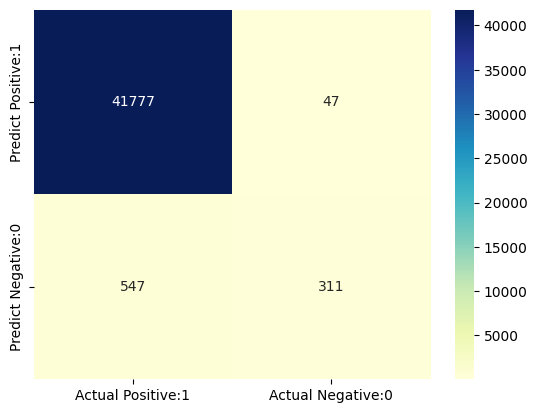

In [ ]:

import seaborn as sns
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')



# Memory

## Создаем датафрейм CPU и обогощаем его признаками

In [ ]:
df_Memory = data.loc[:, ['Time', 'Memory']]
df_Memory= df_Memory.dropna()

df_Memory

,Time,Memory
0,2022-11-01 00:01:00,33.423029
1,2022-11-01 00:02:00,33.544053
2,2022-11-01 00:03:00,33.591381
3,2022-11-01 00:04:00,33.517755
4,2022-11-01 00:05:00,33.417998
...,...,...
190297,2023-03-13 05:49:00,38.012855
190298,2023-03-13 05:50:00,37.881936
190299,2023-03-13 05:51:00,37.891688
190300,2023-03-13 05:52:00,37.946835


In [ ]:
# преобразование столбца 'Time' в формат datetime
df_Memory['Time'] = pd.to_datetime(df_Memory['Time'])

# создание словарей для перевода в One Hot Encoding
week_day_dict = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

month_dict = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}



# добавление столбцов с днем недели, месяцем и днем месяца
df_Memory['Week_day'] = df_Memory['Time'].dt.day_name()
df_Memory['Month'] = df_Memory['Time'].dt.month_name()
df_Memory['Day'] = df_Memory['Time'].dt.day
df_Memory['Hour'] = df_Memory['Time'].dt.hour
df_Memory['Minute'] = df_Memory['Time'].dt.minute

# Преобразование строковых значений в числа из словарей
df_Memory['Week_day'] = df_Memory['Week_day'].replace(week_day_dict)
df_Memory['Month'] = df_Memory['Month'].replace(month_dict)

# перевод категориальных признаков в One Hot Encoding
week_day_ohe = pd.get_dummies(df_Memory['Week_day'], prefix='Week_day_ohe')
month_ohe = pd.get_dummies(df_Memory['Month'], prefix='Month_ohe')
day_ohe = pd.get_dummies(df_Memory['Day'], prefix='Day_ohe')
hour_ohe = pd.get_dummies(df_Memory['Hour'], prefix='Hour_ohe')
minute_ohe = pd.get_dummies(df_Memory['Minute'], prefix='Minute_ohe')

# объединение датафрейма с One Hot Encoding
df_Memory = pd.concat([df_Memory, week_day_ohe, month_ohe, day_ohe, hour_ohe, minute_ohe], axis=1)

# удаление столбцов с категориальными признаками
df_Memory = df_Memory.drop(['Week_day', 	'Month' , 	'Day' , 	'Hour',  	'Minute'], axis=1)

# устанавливаем столбец "Time" в качестве индекса
df_Memory.set_index('Time', inplace=True)

df_Memory

,Memory,Week_day_ohe_1,Week_day_ohe_2,Week_day_ohe_3,Week_day_ohe_4,Week_day_ohe_5,Week_day_ohe_6,Week_day_ohe_7,Month_ohe_1,Month_ohe_2,...,Minute_ohe_50,Minute_ohe_51,Minute_ohe_52,Minute_ohe_53,Minute_ohe_54,Minute_ohe_55,Minute_ohe_56,Minute_ohe_57,Minute_ohe_58,Minute_ohe_59
Time,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:01:00,33.423029,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:02:00,33.544053,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:03:00,33.591381,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:04:00,33.517755,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:05:00,33.417998,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-13 05:49:00,38.012855,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-13 05:50:00,37.881936,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2023-03-13 05:51:00,37.891688,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Регрессия

## Создание входных и выходных X и Y

In [ ]:
# определяем интервал в 2 недели (20160 минут = количеству строк датафрейма ) - за столько времени нам нужно предсказывать превышение CPU 75%
interval = 20160
# в Х пишем верхнюю часть датафрейма без хвоста, равного  interval
x = df_Memory.loc[df_Memory.index[:len(df_Memory)-interval], :]

# В Y пишем столбец CPU без верхних  interval-строк
y = df_Memory.loc[df_Memory.index[interval:], 'Memory']
y = pd.DataFrame(y, columns=['Memory'])

"""
from sklearn.preprocessing import MinMaxScaler
# Создаем объект минимакс-масштабирования
scaler = MinMaxScaler()

# Масштабируем столбец "CPU"
x['CPU'] = scaler.fit_transform(x[['CPU']])
"""
print(x.shape)
print(y.shape)



(170142, 128)
(170142, 1)


In [ ]:
x

,Memory,Week_day_ohe_1,Week_day_ohe_2,Week_day_ohe_3,Week_day_ohe_4,Week_day_ohe_5,Week_day_ohe_6,Week_day_ohe_7,Month_ohe_1,Month_ohe_2,...,Minute_ohe_50,Minute_ohe_51,Minute_ohe_52,Minute_ohe_53,Minute_ohe_54,Minute_ohe_55,Minute_ohe_56,Minute_ohe_57,Minute_ohe_58,Minute_ohe_59
Time,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:01:00,33.423029,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:02:00,33.544053,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:03:00,33.591381,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:04:00,33.517755,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:05:00,33.417998,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-27 05:34:00,35.003382,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2023-02-27 05:35:00,34.858396,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2023-02-27 05:36:00,34.851005,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y

,Memory
Time,
2022-11-15 00:02:00,55.143605
2022-11-15 00:03:00,51.912992
2022-11-15 00:04:00,51.865355
2022-11-15 00:05:00,51.851526
2022-11-15 00:06:00,51.851598
...,...
2023-03-13 05:49:00,38.012855
2023-03-13 05:50:00,37.881936
2023-03-13 05:51:00,37.891688


## Обучение модели


In [ ]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Преобразуем датасеты в массивы NumPy
x = np.array(x)
y = np.array(y)

"""
# Разбиваем данные на обучающую, валидационную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)
"""

# Определение размеров выборок
train_size = int(len(x) * 0.6)  # 60% для обучения
valid_size = int(len(x) * 0.2)  # 20% для валидации
test_size = len(x) - train_size - valid_size  # остаток для тестирования

# Разделение на обучающую, валидационную и тестовую выборки
x_train = x[:train_size]
x_valid = x[train_size:train_size+valid_size]
x_test = x[train_size+valid_size:]

y_train = y[:train_size]
y_valid = y[train_size:train_size+valid_size]
y_test = y[train_size+valid_size:]

# Создаем объекты Dataset для обучающей, валидационной и тестовой выборок
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid)

# Определение параметров модели
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 200,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Обучение модели
num_iterations = 1000
model = lgb.train(params, train_data, num_iterations, valid_sets=[valid_data], verbose_eval=False)




/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006075 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
# Получение прогнозов на тестовой выборке
y_pred = model.predict(x_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE): {0:0.4f}'.format(mae))
print('Mean Squared Error (MSE): {0:0.4f}'.format(mse))
print('R-squared: {0:0.4f}'.format(r2))


Mean Absolute Error (MAE): 9.0404
Mean Squared Error (MSE): 159.0459
R-squared: -0.0495


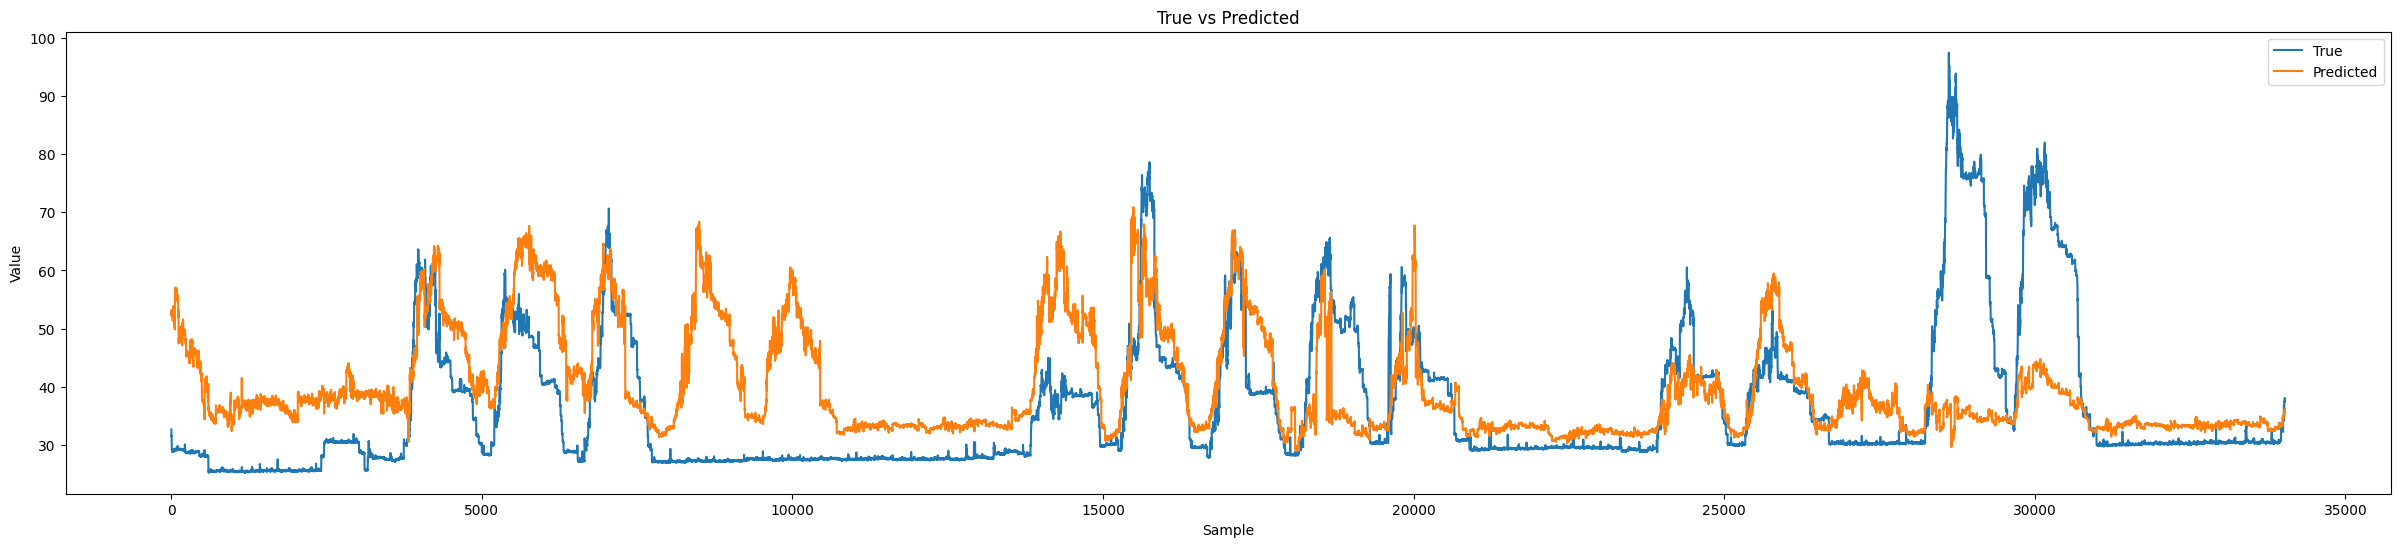

In [ ]:
import matplotlib.pyplot as plt

# График истинных значений и предсказаний
plt.figure(figsize=(30, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('True vs Predicted')
plt.legend()
plt.show()


## Классификация

In [ ]:
# определяем интервал в 2 недели (20160 минут = количеству строк датафрейма ) - за столько времени нам нужно предсказывать превышение CPU 75%
interval = 20160
# в Х пишем верхнюю часть датафрейма без хвоста, равного  interval
x = df_Memory.loc[df_Memory.index[:len(df_Memory)-interval], :]

# В Y пишем столбец CPU без верхних  interval-строк
y = df_Memory.loc[df_Memory.index[interval:], 'Memory']
y = pd.DataFrame(y, columns=['Memory'])
"""
from sklearn.preprocessing import MinMaxScaler
# Создаем объект минимакс-масштабирования
scaler = MinMaxScaler()

# Масштабируем столбец "CPU"
x['CPU'] = scaler.fit_transform(x[['CPU']])
"""
print(x.shape)
print(y.shape)

(170142, 128)
(170142, 1)


In [ ]:
x

,CPU,Week_day_ohe_1,Week_day_ohe_2,Week_day_ohe_3,Week_day_ohe_4,Week_day_ohe_5,Week_day_ohe_6,Week_day_ohe_7,Month_ohe_1,Month_ohe_2,...,Minute_ohe_50,Minute_ohe_51,Minute_ohe_52,Minute_ohe_53,Minute_ohe_54,Minute_ohe_55,Minute_ohe_56,Minute_ohe_57,Minute_ohe_58,Minute_ohe_59
Time,,,,,,,,,,,,,,,,,,,,,
2022-11-01 00:01:00,14.218750,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:02:00,13.554688,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:03:00,14.453125,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:04:00,26.015625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-11-01 00:05:00,15.390625,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 07:07:00,26.093750,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-29 07:08:00,8.632813,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-03-29 07:09:00,9.960938,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Проверяем условие и присваиваем значения 1 или 0
y['Memory'] = y['Memory'].apply(lambda x: 1 if x > 80 else 0)
# Преобразуем столбец "CPU" в One-Hot Encoding
y

,Memory
Time,
2022-11-15 00:02:00,0
2022-11-15 00:03:00,0
2022-11-15 00:04:00,0
2022-11-15 00:05:00,0
2022-11-15 00:06:00,0
...,...
2023-03-13 05:49:00,0
2023-03-13 05:50:00,0
2023-03-13 05:51:00,0


In [ ]:
# Преобразуем датасеты в массивы NumPy
x = np.array(x)
y = np.array(y)

"""
# Определение размеров выборок
train_size = int(len(x) * 0.6)  # 60% для обучения
valid_size = int(len(x) * 0.2)  # 20% для валидации
test_size = len(x) - train_size - valid_size  # остаток для тестирования

# Разделение на обучающую, валидационную и тестовую выборки
x_train = x[:train_size]
x_valid = x[train_size:train_size+valid_size]
x_test = x[train_size+valid_size:]

y_train = y[:train_size]
y_valid = y[train_size:train_size+valid_size]
y_test = y[train_size+valid_size:]
"""

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, random_state=0)


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(np.sum(y_train, axis=0))

print(x_valid.shape)
print(y_valid.shape)
print(np.sum(y_valid, axis=0))

print(x_test.shape)
print(y_test.shape)
print(np.sum(y_test, axis=0))

(102084, 128)
(102084, 1)
[1090]
(34029, 128)
(34029, 1)
[383]
(34029, 128)
(34029, 1)
[360]


In [ ]:
# build the lightgbm model
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


LGBMClassifier()

In [ ]:
# predict the results
y_pred=clf.predict(x_test)

In [ ]:
y_pred_train = clf.predict(x_train)


In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(clf.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(x_test, y_test)))

Training set score: 0.9996
Test set score: 0.9979


In [ ]:
# view confusion-matrix
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[33624    45]
 [   27   333]]

True Positives(TP) =  33624

True Negatives(TN) =  333

False Positives(FP) =  45

False Negatives(FN) =  27


<Axes: >

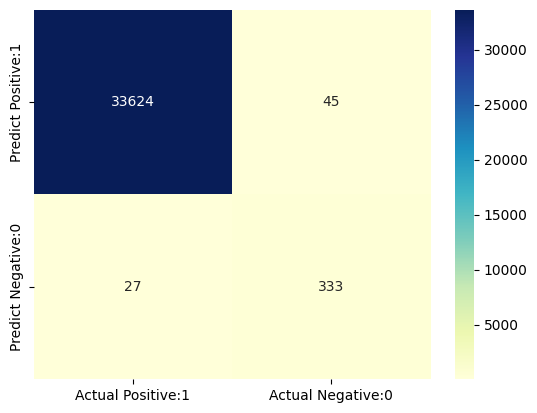

In [ ]:

import seaborn as sns
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

